# Work with multiple injections

In [267]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sclitr as sl

sc.set_figure_params(dpi=80)
sns.set_style("ticks")

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


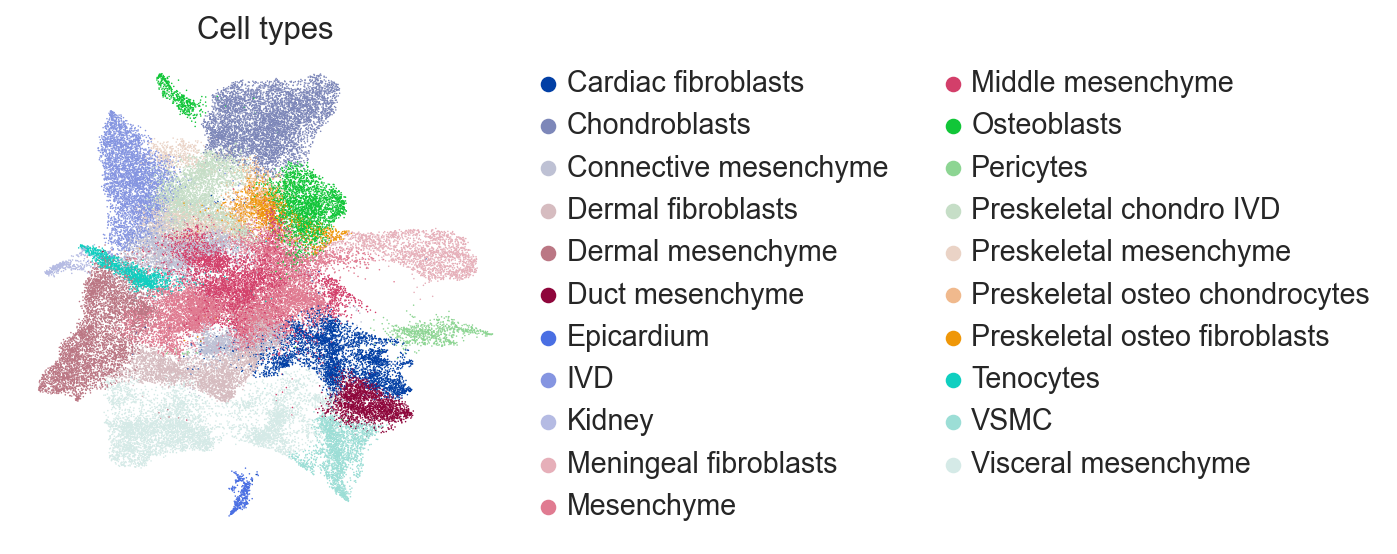

In [268]:
adata = sl.datasets.Erickson_murine_development(subset="mesenchyme")

sc.pl.umap(adata, color="celltype_l2", frameon=False, title="Cell types")

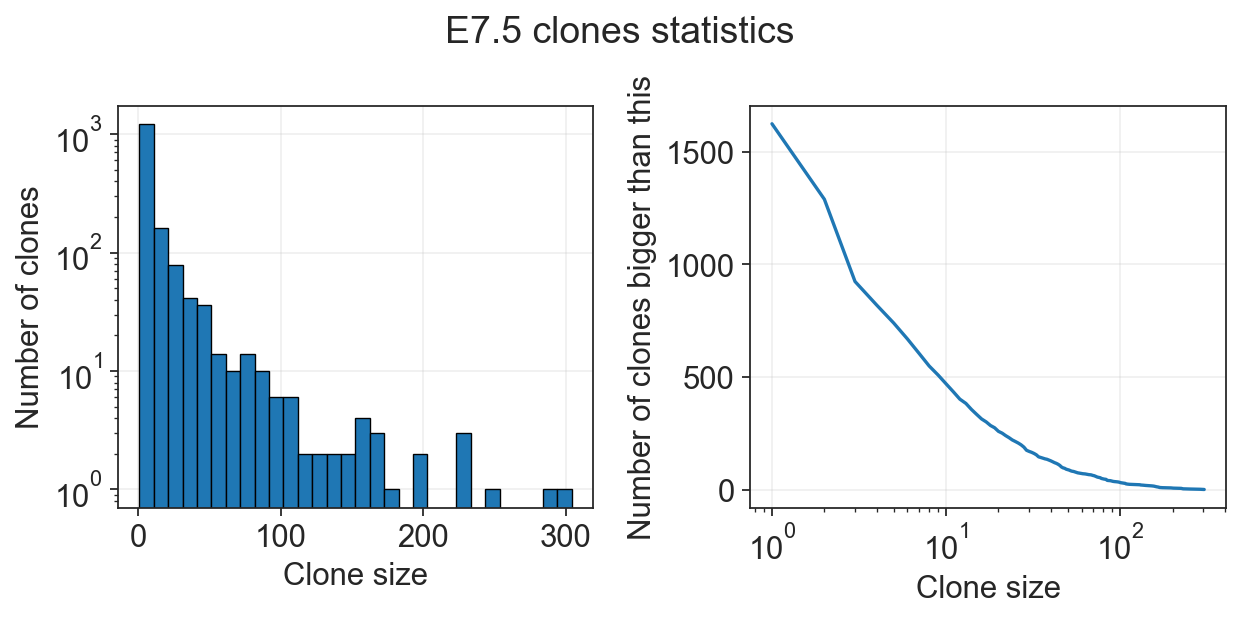

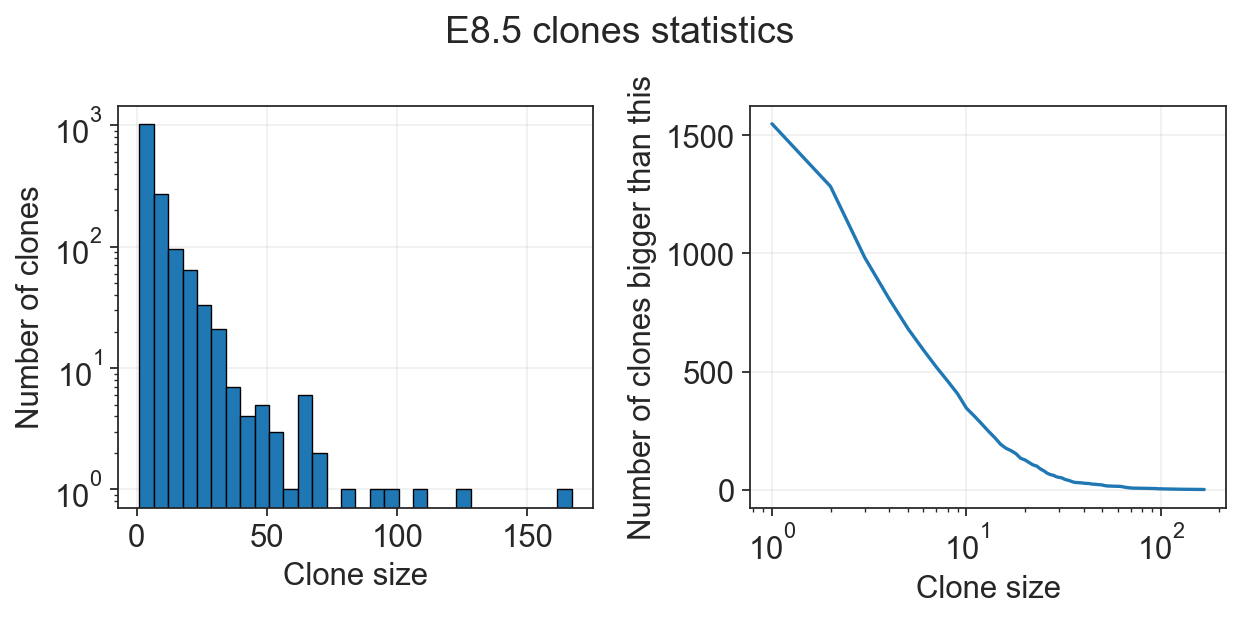

In [269]:
sl.pl.basic_stats(adata, obs_name="E7.5:clones", title="E7.5 clones statistics")
sl.pl.basic_stats(adata, obs_name="E8.5:clones", title="E8.5 clones statistics")

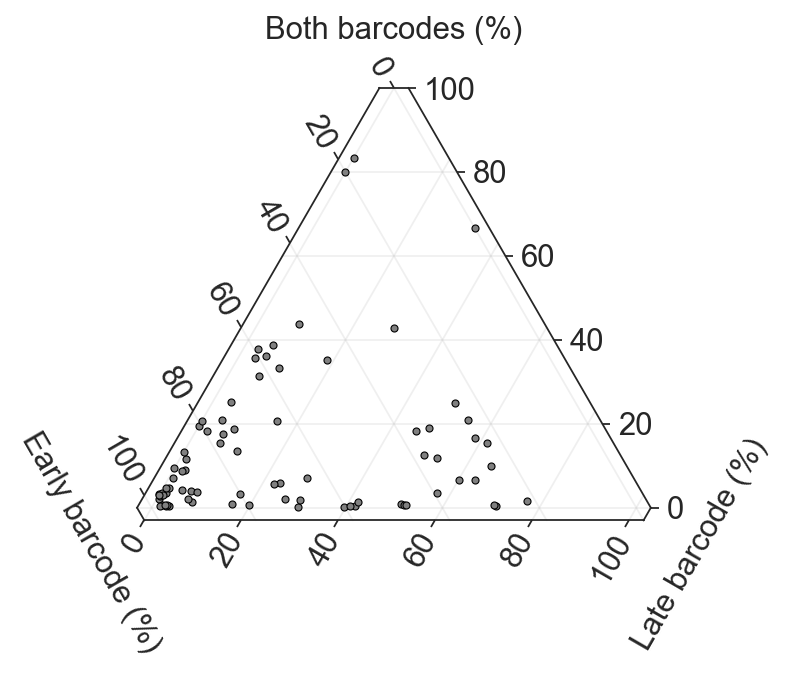

In [270]:
# Right now it works only with double injections

sl.pl.double_injection_composition(
    adata,
    early_injection="E7.5:clones",
    late_injection="E8.5:clones",
)

## Embedding preparation

In [4]:
adata_demult = sl.pp.prepare_multiple_injections(
    adata,
    injection_cols=["E7.5:clones", "E8.5:clones"],
)

/home/sergey/tools/sclitr/sclitr/preprocessing.py:25: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for label, clone in clonal_labels[clonal_labels != na_value].iteritems():
/home/sergey/tools/sclitr/sclitr/preprocessing.py:30: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_demult.obs[final_obs_name] = clone_obs
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1898: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [14]:
sl.tl.clonal_nn(
    adata_demult,
    obs_name="clone",
    use_rep="X_pca_harmony",
    min_size=5,
    tqdm_bar=True,
)

100%|██████████| 62778/62778 [01:02<00:00, 1005.00it/s]


In [16]:
clones = sl.tl.clone2vec(
    adata_demult,
    obs_name="clone",
    fill_ct="celltype_l2",
    device="cuda:0",
    n_epochs=50,
)

100%|██████████| 50/50 [08:47<00:00, 10.55s/it]
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


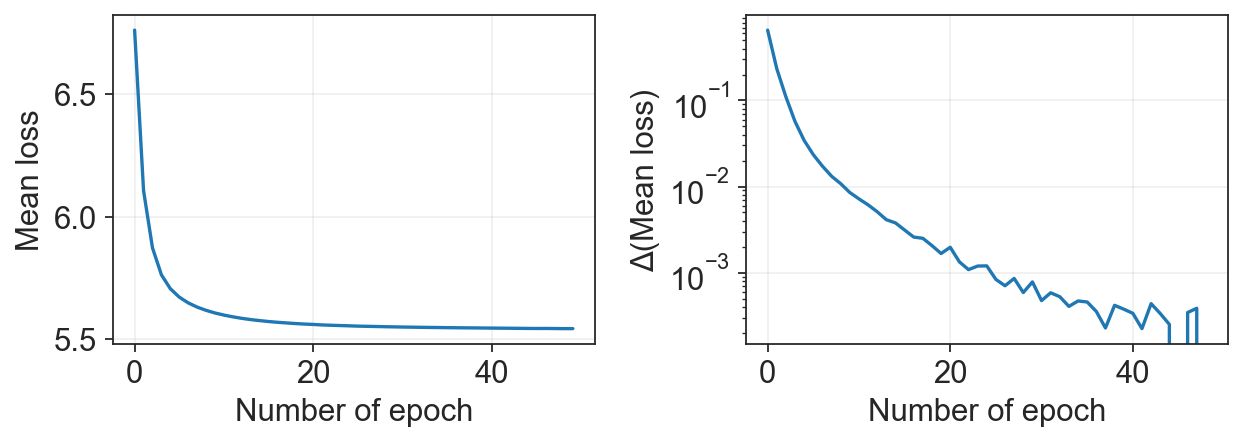

In [271]:
sl.pl.epochs_loss(clones)

In [18]:
sc.pp.neighbors(clones, use_rep="word2vec", n_neighbors=15)
sc.tl.umap(clones)

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/umap/distances.

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


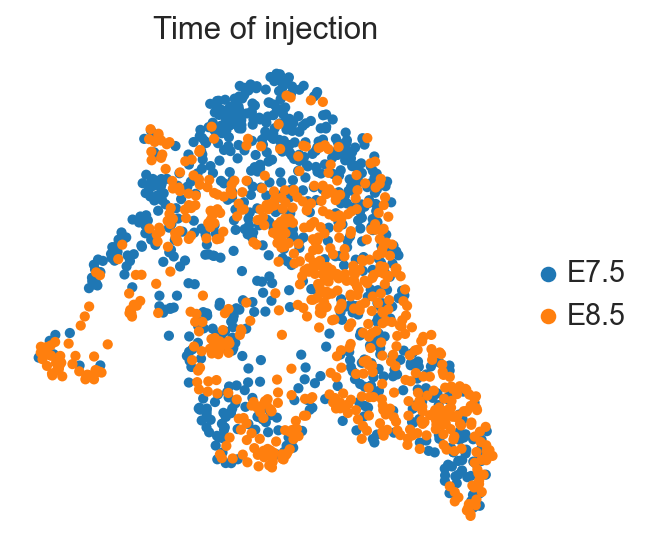

In [272]:
clones.obs["timepoint"] = [i.split(":")[0] for i in clones.obs_names]

sc.pl.umap(clones, color="timepoint", frameon=False, title="Time of injection")

## Plotting of average expression per clone

In [24]:
clones_expr = sl.tl.summarize_expression(
    adata_demult,
    obs_name="clone",
    clones=clones,
)

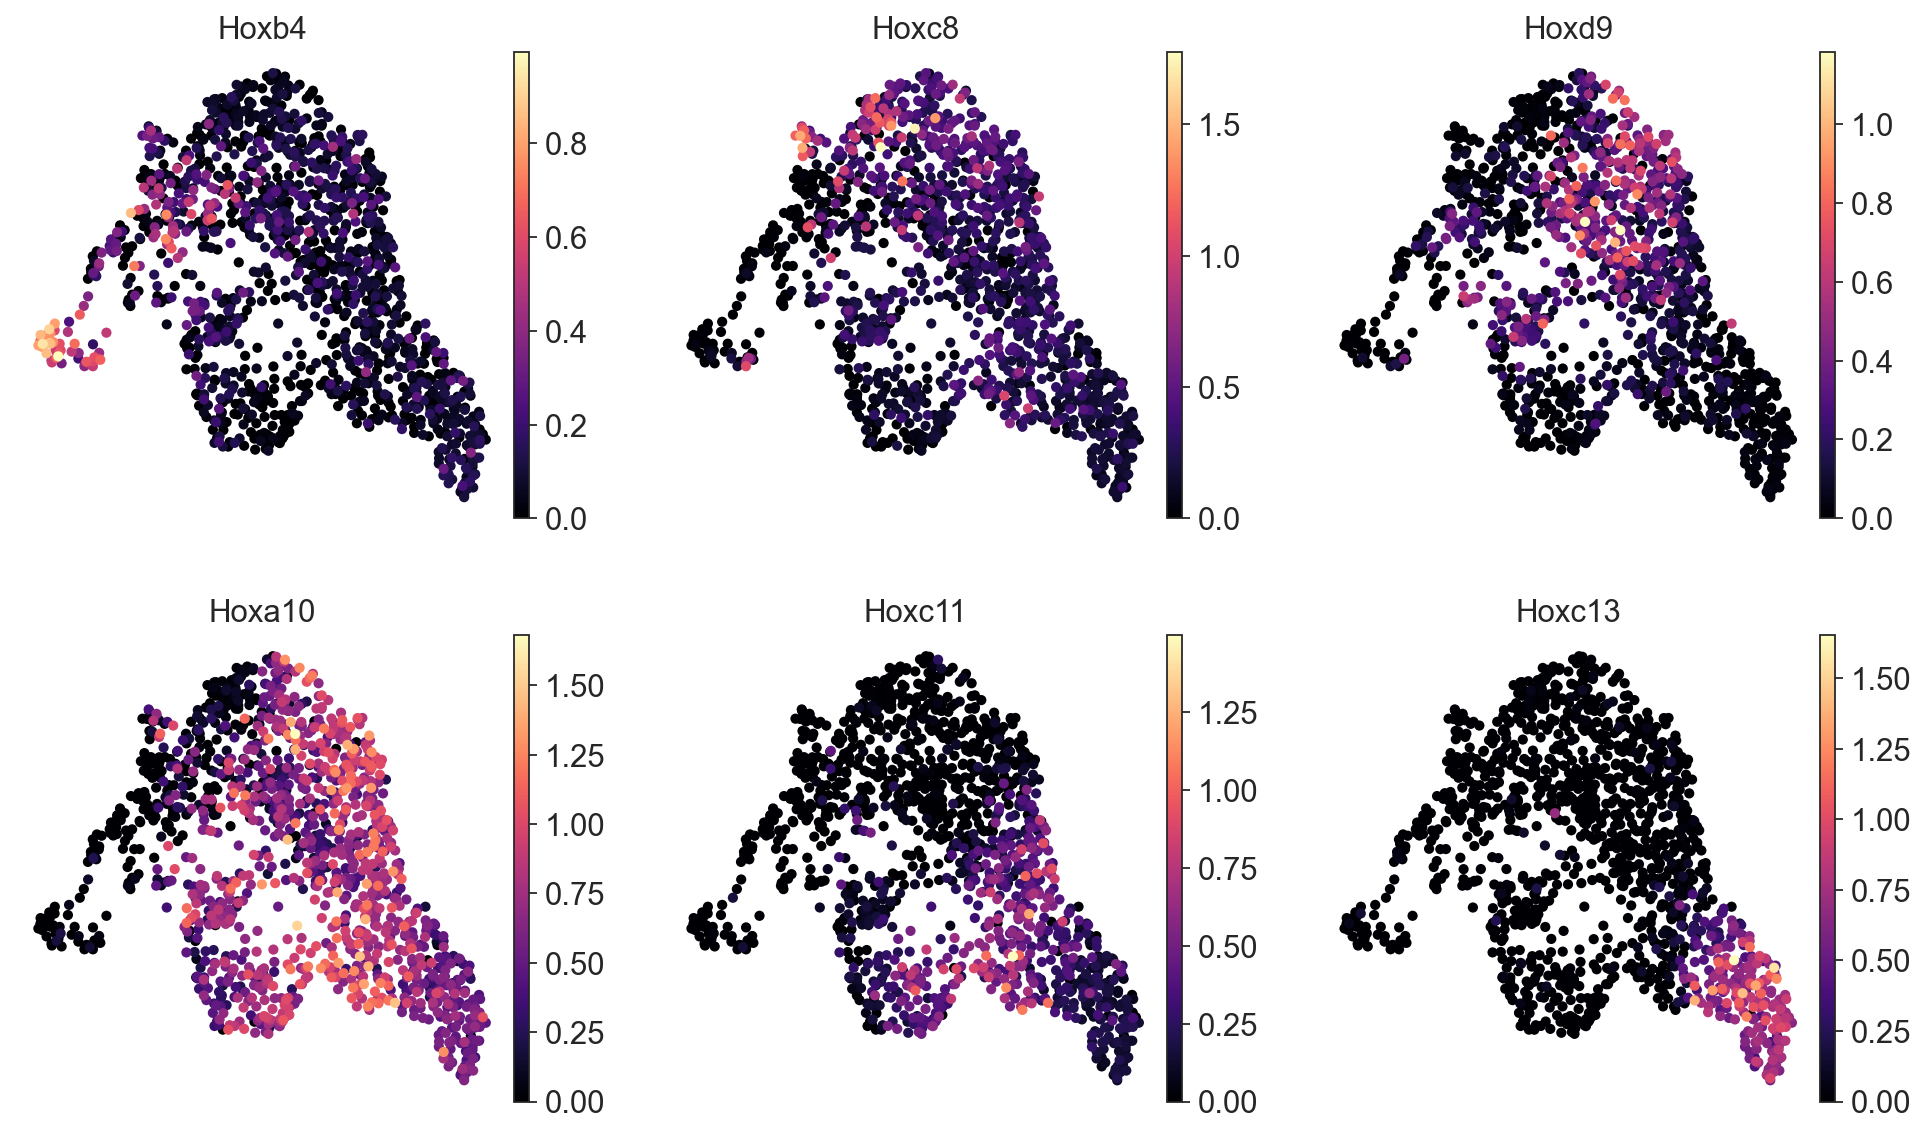

In [273]:
sc.pl.umap(
    clones_expr,
    color=["Hoxb4", "Hoxc8", "Hoxd9", "Hoxa10", "Hoxc11", "Hoxc13"],
    frameon=False,
    cmap="magma",
    ncols=3
)

## Clonal clustering

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


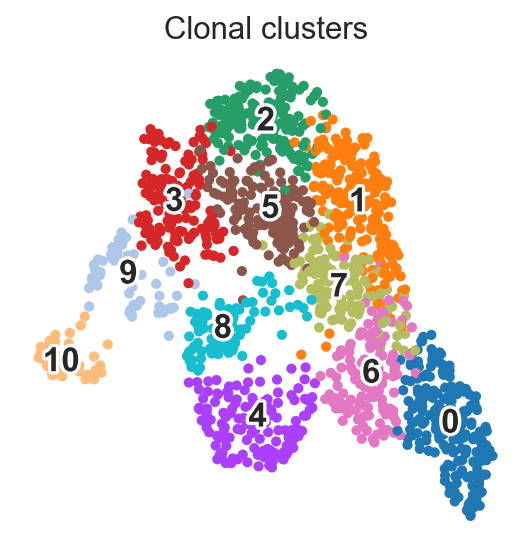

In [274]:
sc.tl.leiden(clones, resolution=1)

sc.pl.umap(
    clones,
    color="leiden",
    frameon=False,
    title="Clonal clusters",
    legend_loc="on data",
    legend_fontsize=15,
    legend_fontoutline=3
)

In [256]:
sl.tl.transfer_clonal_annotation(
    adata_demult,
    clones,
    adata_clone_name="clone",
    adata_obs_name="Clonal cluster",
    clones_obs_name="leiden",
    fill_values="NA",
)

/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sergey/miniconda3/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colorm

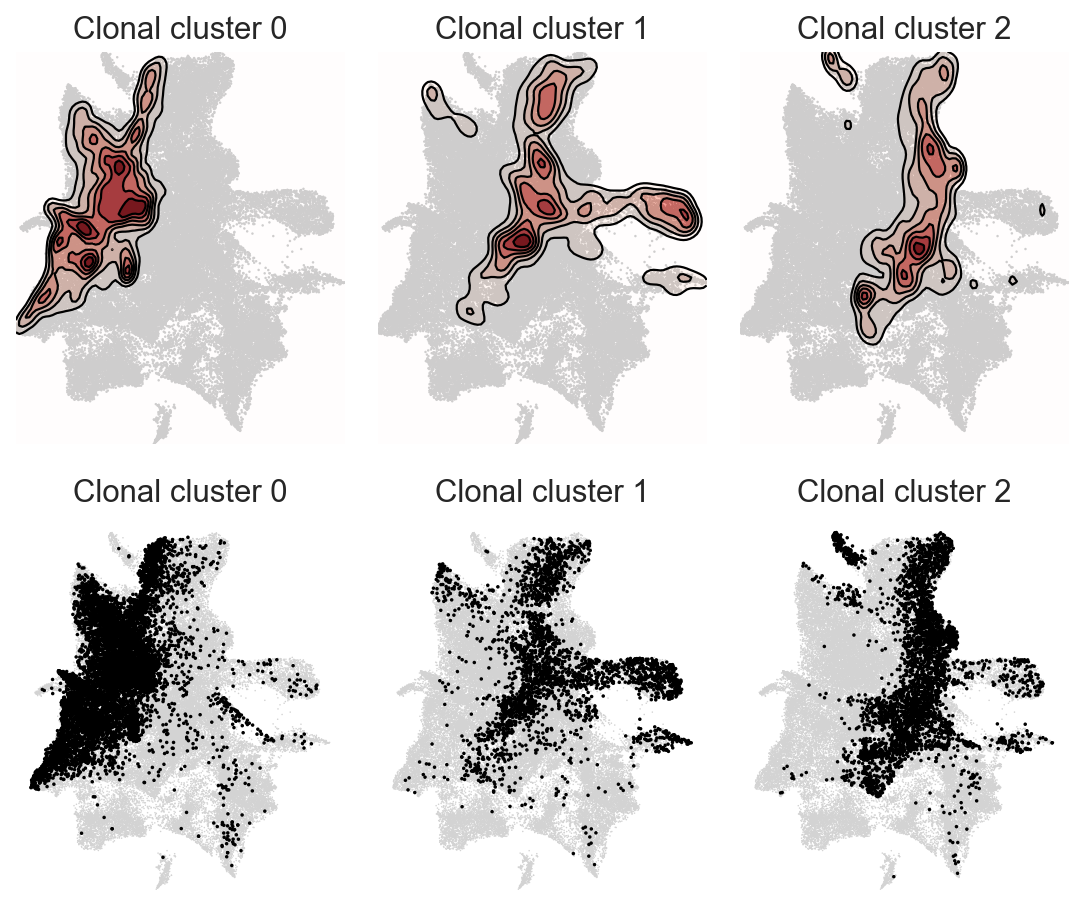

In [277]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(7, 6))

for i, clonal_cluster in enumerate(["0", "1", "2"]):
    sl.pl.kde(
        adata_demult,
        groupby="Clonal cluster",
        group=clonal_cluster,
        title=f"Clonal cluster {clonal_cluster}",
        ax=axes[0, i],
    )

    sl.pl.clone(
        adata_demult,
        clone_col="Clonal cluster",
        clone_name=clonal_cluster,
        title=f"Clonal cluster {clonal_cluster}",
        s=10,
        ax=axes[1, i],
    )
    
fig.tight_layout()